# EDA Dataset Hotels

## Dataset

Ce jeu de données est issu du site tidymodels.

Je reprends leur description :
"Let’s use hotel bookings data from Antonio, Almeida, and Nunes (2019) to predict which hotel stays included children and/or babies, based on the other characteristics of the stays such as which hotel the guests stay at, how much they pay, etc. This was also a #TidyTuesday dataset with a data dictionary you may want to look over to learn more about the variables. We’ll use a slightly edited version of the dataset for this case study."



#### Import du jeu de données

In [14]:
import sys
sys.path.append("../scripts")   # car ton notebook est dans notebooks/

import utils

import pandas as pd

df = pd.read_csv("../data/raw/hotels.csv")
print(df.shape)
df.head()

(50000, 23)


,hotel,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,meal,country,market_segment,distribution_channel,...,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,average_daily_rate,required_car_parking_spaces,total_of_special_requests,arrival_date
0,City_Hotel,217,1,3,2,none,BB,DEU,Offline_TA/TO,TA/TO,...,A,A,0,No_Deposit,0,Transient-Party,80.75,none,1,2016-09-01
1,City_Hotel,2,0,1,2,none,BB,PRT,Direct,Direct,...,D,K,0,No_Deposit,0,Transient,170.00,none,3,2017-08-25
2,Resort_Hotel,95,2,5,2,none,BB,GBR,Online_TA,TA/TO,...,A,A,2,No_Deposit,0,Transient,8.00,none,2,2016-11-19
3,Resort_Hotel,143,2,6,2,none,HB,ROU,Online_TA,TA/TO,...,A,A,0,No_Deposit,0,Transient,81.00,none,1,2016-04-26
4,Resort_Hotel,136,1,4,2,none,HB,PRT,Direct,Direct,...,F,F,0,No_Deposit,0,Transient,157.60,none,4,2016-12-28


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           50000 non-null  object 
 1   lead_time                       50000 non-null  int64  
 2   stays_in_weekend_nights         50000 non-null  int64  
 3   stays_in_week_nights            50000 non-null  int64  
 4   adults                          50000 non-null  int64  
 5   children                        50000 non-null  object 
 6   meal                            50000 non-null  object 
 7   country                         49711 non-null  object 
 8   market_segment                  50000 non-null  object 
 9   distribution_channel            50000 non-null  object 
 10  is_repeated_guest               50000 non-null  int64  
 11  previous_cancellations          50000 non-null  int64  
 12  previous_bookings_not_canceled  

Contrairement au langage R qui permet via la commande glimpse de détecter automatiquement ce qui releève du string et du factor, en python nous travaillons avec object. 
dans une perspective d'utiliser ultérieuement des encoders, on reproduit l'approche tidymodels de R.


In [16]:
for col in df.select_dtypes(include="object").columns:
    df[col] = df[col].astype("category")
print(df.dtypes.head(10))

hotel                      category
lead_time                     int64
stays_in_weekend_nights       int64
stays_in_week_nights          int64
adults                        int64
children                   category
meal                       category
country                    category
market_segment             category
distribution_channel       category
dtype: object


On émule le glimpse de R

In [17]:
utils.glimpse(df)

Rows: 50000 | Columns: 23

hotel                     category   non-null: 50000  unique: 2      preview: ['City_Hotel', 'Resort_Hotel']
Categories (2, object): ['City_Hotel', 'Resort_Hotel']
lead_time                 int64      non-null: 50000  unique: 414    preview: [217   2  95 143 136]
stays_in_weekend_nights   int64      non-null: 50000  unique: 17     preview: [1 0 2 4 3]
stays_in_week_nights      int64      non-null: 50000  unique: 31     preview: [3 1 5 6 4]
adults                    int64      non-null: 50000  unique: 5      preview: [2 0 1 3 4]
children                  category   non-null: 50000  unique: 2      preview: ['none', 'children']
Categories (2, object): ['children', 'none']
meal                      category   non-null: 50000  unique: 5      preview: ['BB', 'HB', 'SC', 'Undefined', 'FB']
Categories (5, object): ['BB', 'FB', 'HB', 'SC', 'Undefined']
country                   category   non-null: 49711  unique: 154    preview: ['DEU', 'PRT', 'GBR', 'ROU', 'ESP']
Cat

In [18]:
""" from pathlib import Path
import pandas as pd
import time

# 1) S'assurer que le dossier existe
out_dir = Path("../data/processed")
out_dir.mkdir(parents=True, exist_ok=True)

# 2) Nom de fichier (si verrou, on suffixe l’heure)
out_path = out_dir / "hotels_clean.xlsx"
if out_path.exists():
    try:
        out_path.rename(out_path)  # test de lock: si ça échoue, on renomme plus bas
    except Exception:
        ts = time.strftime("%Y%m%d-%H%M%S")
        out_path = out_dir / f"hotels_clean_{ts}.xlsx"

# 3) Écriture explicite avec openpyxl et handle propre
with pd.ExcelWriter(out_path, engine="openpyxl", mode="w") as writer:
    df.to_excel(writer, index=False)

print(f"✅ Fichier enregistré : {out_path}") """

' from pathlib import Path\nimport pandas as pd\nimport time\n\n# 1) S\'assurer que le dossier existe\nout_dir = Path("../data/processed")\nout_dir.mkdir(parents=True, exist_ok=True)\n\n# 2) Nom de fichier (si verrou, on suffixe l’heure)\nout_path = out_dir / "hotels_clean.xlsx"\nif out_path.exists():\n    try:\n        out_path.rename(out_path)  # test de lock: si ça échoue, on renomme plus bas\n    except Exception:\n        ts = time.strftime("%Y%m%d-%H%M%S")\n        out_path = out_dir / f"hotels_clean_{ts}.xlsx"\n\n# 3) Écriture explicite avec openpyxl et handle propre\nwith pd.ExcelWriter(out_path, engine="openpyxl", mode="w") as writer:\n    df.to_excel(writer, index=False)\n\nprint(f"✅ Fichier enregistré : {out_path}") '

## Premère analyse exploratoire avec le jeu de données sauvegardé

In [19]:
# Import du dataset avec les facteurs

df_excel = pd.read_excel("../data/processed/hotels_clean.xlsx")

Matrice des enfants et proportion en python

In [20]:
utils.matrice_display(df, "children")

,count,proportion
children,,
children,4038,0.08076
none,45962,0.91924


Première analyse :

Un chausse trape classique dans les jeux de données et la création de modèle, est la fameuse "class imbalance" ou déséquilibre de classes.
Dans ce cas, 92% des réservations ne contiennent pas d'enfants.

Ceci va forcément affecter les modèles de prédiction si ce n'est pas traiter. 

Plusieurs stratégies sont envisageables pour traiter les déséquilibres et nécessiteraient aussi de vérifier la distribution sur d'autres colonnes.
- Resampling : avec soit un oversampling de la minorite soit le contraire un undersampling. 
- Pondération de la perte de la classe minoritaire en régression logistique ou RandomForest
- Encoder aussi pour le traitement plus tard (0 ou 1) en feature engineering
- compléter si possible le jeu de données minoritaire, uniquement si c'est pertinent et réaliste


Avant de procéder à du resampling et du splitting, poursuivons notre exploration rapide du dataset.

### Exploration visuelle avec seaborn

#### Exploration des champs numériques

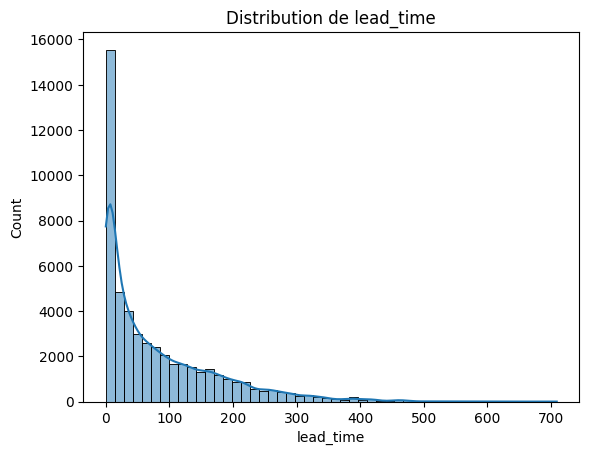

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Histogramme avec kernel density
sns.histplot(df["lead_time"], bins=50, kde=True)
plt.title("Distribution de lead_time")
plt.show()



C’est un indicateur classique en hôtellerie / tourisme : plus le lead time est grand, plus le client a eu le temps de comparer et plus le risque d’annulation peut être élevé.
Le graphe met en évidence :
- Un énorme pic autour de 0–10 jours → beaucoup de réservations faites à la dernière minute.
- Une distribution très asymétrique (skewed right) → longue traîne jusqu’à plus de 700 jours (≈ 2 ans d’avance).
- Que la plupart des clients réservent moins de 100 jours avant leur arrivée.

Interprétaion Business envisageable :
- Les réservations de dernière minute sont dominantes → probablement clientèle locale ou opportuniste.
- Les réservations très anticipées (200–700 jours) sont rares, mais souvent associées à des groupes, des congrès, ou des voyageurs internationaux qui planifient très longtemps à l’avance.

Pour la modélisation (is_canceled) :
- Plus le lead_time est grand, plus la probabilité d’annulation est élevée (on pourra vérifier via un boxplot/violin plot).
- Les très courts lead_time (0–7 jours) sont en général beaucoup plus stables (moins d’annulations).


/var/folders/cy/g5387q010fs09y6zwn2qh7l80000gn/T/ipykernel_91177/1575754794.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


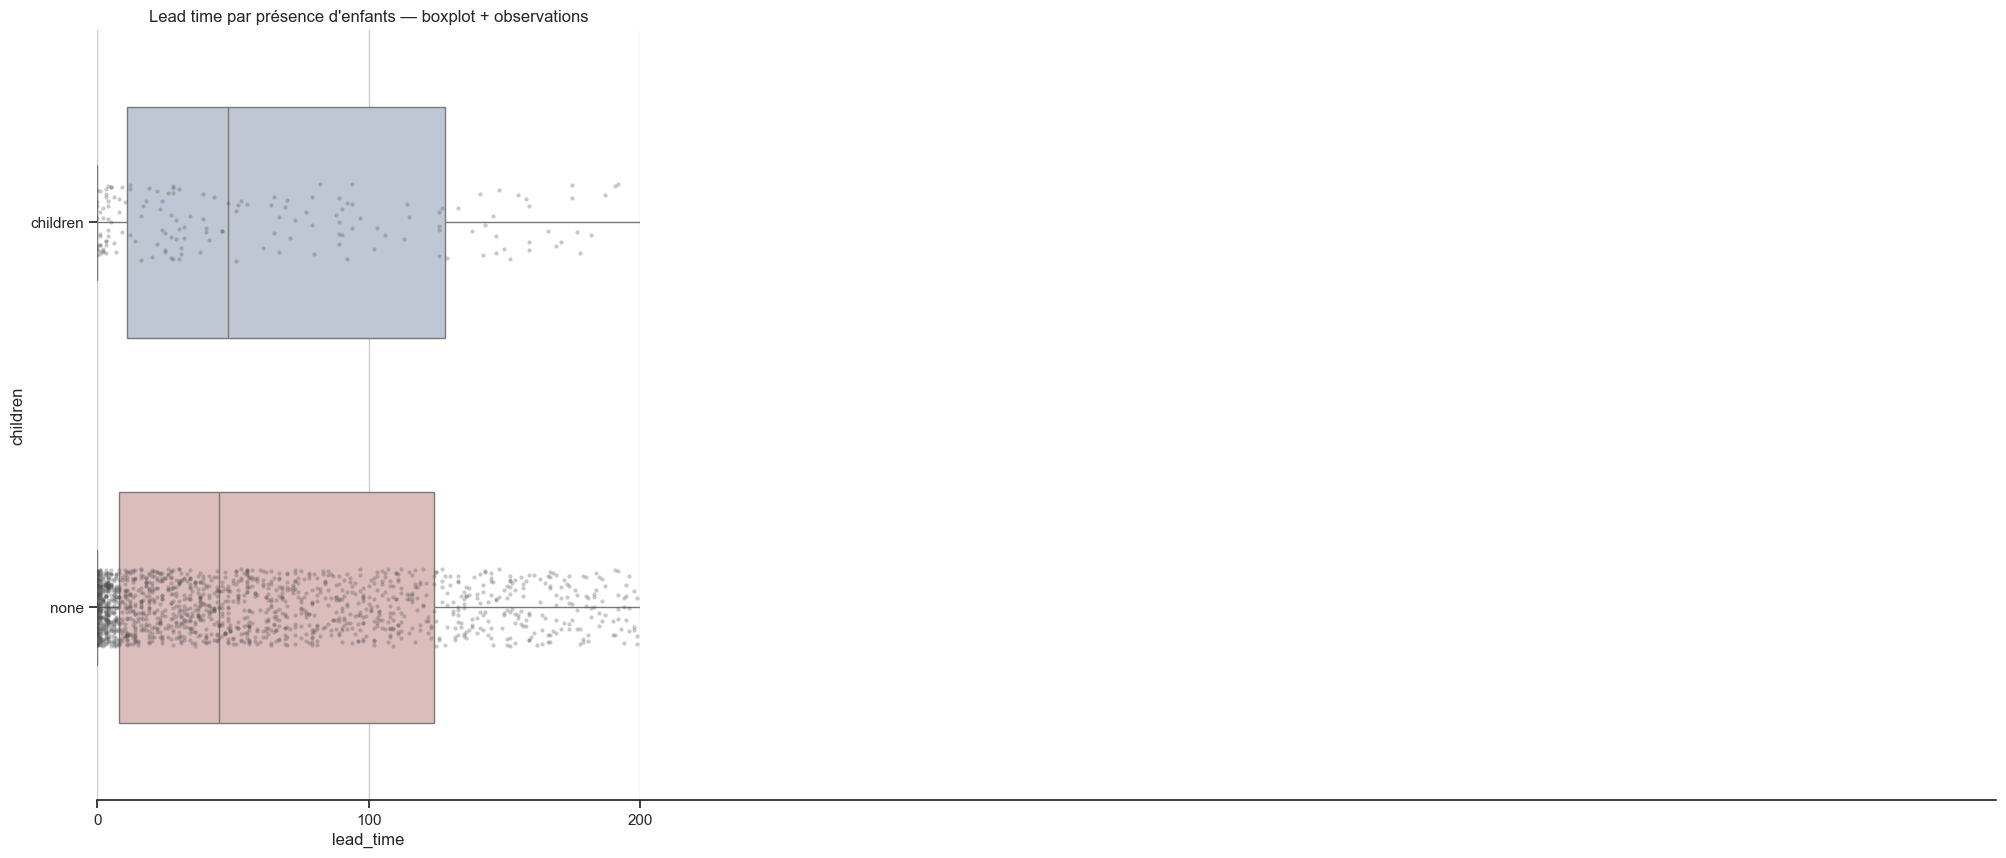

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="ticks")

# Initialiser la figure
f, ax = plt.subplots(figsize=(7, 10))

# Boxplots horizontaux
sns.boxplot(
    data=df,
    x="lead_time", 
    y="children",
    whis=[0, 100],     # whiskers = min/max
    width=0.6,
    palette="vlag",
    ax=ax
)

# Ajouter les points d'observation (échantillon pour éviter de ramer)
df_sample = df.sample(2000, random_state=42)
sns.stripplot(
    data=df_sample,
    x="lead_time", 
    y="children",
    size=3, color=".3", alpha=0.3, jitter=True, ax=ax
)

# Présentation visuelle
ax.grid(True, axis="x")
ax.set(xlabel="lead_time", ylabel="children")
sns.despine(trim=True, left=True)

plt.title("Lead time par présence d'enfants — boxplot + observations", fontsize=12)
plt.xlim(0, 200)   # zoom utile
plt.show()

Constats visibles :

1.  Beaucoup d’outliers
    - Les valeurs de lead_time au-delà de 365 jours (voire 700) sont rares mais présentes.
	- C’est normal : certaines réservations très anticipées existent (ex. congrès, mariages, tours opérateurs).
	- Côté modélisation : tu devras arbitrer → les garder (signal métier rare) ou les tronquer (bruit).
2.  Médiane et IQR quasi identiques entre “children” et “none”
	- Ça veut dire que, dans ce dataset, la présence d’enfants n’influence pas le délai de réservation.
	- Ce n’est pas à priori pas une erreur : statistiquement, les distributions sont très proches.
	- La différence éventuelle se joue dans les “queues” (outliers), pas dans le cœur de la distribution.

Constats visuels confirmés par le nuage de points : 

Déséquilibre de classe

- Il ya beaucoup plus d’observations dans la modalité none (pas d’enfants) que dans children.
- Visuellement, on voit un nuage dense en bas et plus clair en haut → reflet direct du class imbalance déjà quantifié (≈ 92% vs 8%).

Distributions de lead_time assez proches
- Les médianes et IQR sont très similaires entre les deux groupes.
- Cela confirme ce qu’on observait : la présence d’enfants n’influence pas vraiment le délai de réservation.
- Les  différences se trouvent surtout dans les extrêmes (outliers), mais le cœur est identique.

⸻

Interprétation métier pour la modélisation,ça veut dire:

- Peu de signal discriminant : children n’apportera probablement pas grand-chose pour prédire is_canceled.
- Class imbalance : si on utilise cette variable comme cible (ou combinée), il faudra corriger via pondération/échantillonnage.

⸻

Pour aller plus loin ?

- Croiser children avec is_canceled → voir si, malgré le déséquilibre, les familles annulent plus/moins souvent.
- Croiser avec hotel ou market_segment → peut-être que la différence apparaît seulement dans certains segments (ex. Resort Hotel + enfants).
- Passer à une ECDF (courbe cumulative) pour comparer plus finement les distributions de lead_time.